In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd

In [16]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
Measurement.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

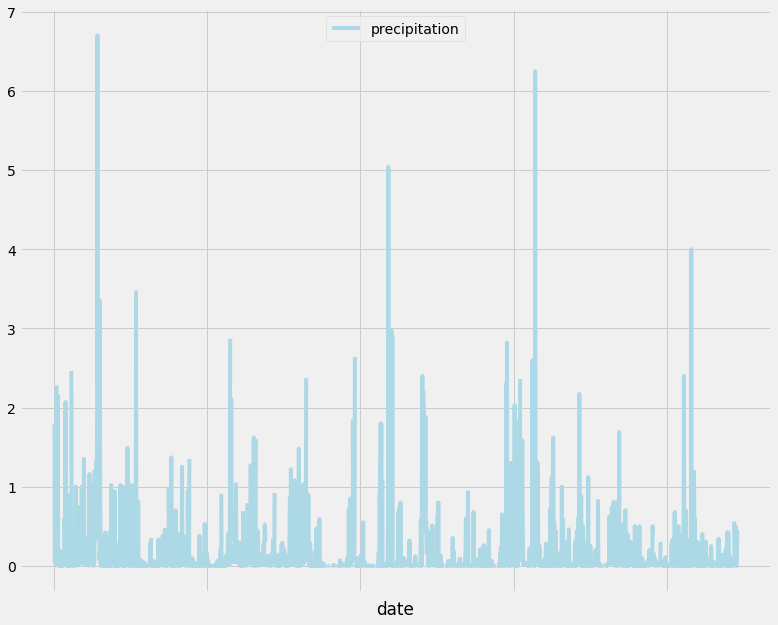

In [165]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#engine.execute('select * from measurement').fetchall(
from datetime import date, timedelta, datetime
# Calculate the date 1 year ago from the last data point in the database
latest_row = session.query(Measurement).order_by(Measurement.date.desc()).first()
latest_date = datetime.strptime(latest_row.date, '%Y-%m-%d')
date_12_months_ago = latest_date.date() - timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
last_12mon_data = session.query(Measurement).filter(Measurement.date > date_12_months_ago)


# Save the query results as a Pandas DataFrame and set the index to the date column
conn = engine.connect()
data_measurement = pd.read_sql("SELECT * from Measurement where date > '{}'".format(date_12_months_ago.isoformat()), conn)
data_measurement = data_measurement.set_index(["date"])

# Sort the dataframe by date
data_measurement_sorted =data_measurement.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
data_measurement_sorted = data_measurement_sorted.rename(columns={"prcp": "precipitation"})
fig = plt.figure(figsize=(12, 10))
data_measurement_sorted.precipitation.plot(kind="line",color="lightblue",legend = True).legend(loc="upper center")


# last_12mon_data
# date_12_months_ago.isoformat()
# for f in last_12mon_data:
#     print("{} - {}".format(f.date, f.prcp))
# date_12_months_ago.isoformat()
# last_12mon_data
# last_12mon_data
#data_measurement_sorted




![precipitation](Images/precipitation.png)

In [203]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_data = data_measurement_sorted.describe()
summary_data = summary_data[["precipitation"]]
summary_data

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [257]:
# Design a query to show how many stations are available in this dataset?
measurement_dataset = pd.read_sql("SELECT * from Measurement",conn)
unique_station = len(measurement_dataset["station"].unique())

unique_station


9

In [254]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = measurement_dataset.groupby("station").count()
station_count =station_count.sort_values(by='id', ascending=False)
station_count_df = station_count[["id"]]
station_count_df = station_count_df.rename(columns={"id": "count"})
station_count_df


,id,date,prcp,tobs
station,,,,
USC00519281,2772,2772,2772,2772
USC00519397,2724,2724,2685,2724
USC00513117,2709,2709,2696,2709
USC00519523,2669,2669,2572,2669
USC00516128,2612,2612,2484,2612
USC00514830,2202,2202,1937,2202
USC00511918,1979,1979,1932,1979
USC00517948,1372,1372,683,1372
USC00518838,511,511,342,511


In [239]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_count_min = measurement_dataset.groupby("station").min()
station_count_min_mean = station_count_min["tobs"].mean()
station_count_min_mean

56.666666666666664

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [240]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [253]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
data_station = pd.read_sql("SELECT * from Station",conn)

combined_data = pd.merge(data_measurement_sorted,data_station,how='left',on="station")

combined_data_sorted =combined_data.sort_values(by='precipitation', ascending=False)
                           
combined_data_sorted        




,id_x,station,precipitation,tobs,id_y,name,latitude,longitude,elevation
142,19223,USC00516128,6.70,73.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1570,12080,USC00519523,6.25,70.0,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1091,12013,USC00519523,5.04,70.0,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2079,19519,USC00516128,4.00,72.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
268,19243,USC00516128,3.46,74.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
150,19224,USC00516128,3.35,73.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1101,14781,USC00519281,2.98,70.0,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1104,5265,USC00513117,2.90,69.0,2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
575,19289,USC00516128,2.87,71.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1478,19426,USC00516128,2.82,72.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
